### ERDDAP 2018 Oculus Glider QuickLooks and Analysis

#### Puget Sound Spring Test for SG403

Glider Data is subsetted into various components to be hosted on ERDDAP due to mulitple time dimensions

Tested with Python >= 3.6

In [6]:
from erddapy import ERDDAP
import pandas as pd
import numpy as np
import datetime
import xarray

server_url = 'http://downdraft.pmel.noaa.gov:8080/erddap'

e = ERDDAP(server=server_url)

In [7]:
df = pd.read_csv(e.get_search_url(response='csv', search_for='sg403'))

The dataset is spread across multiple datasets in the erddap server so we will need to join them all together

In [8]:
sg403 = df['Dataset ID'].values
print(sg403)

['sg403_PS_spring18' 'sg403_PS_spring18_aanderaa'
 'sg403_PS_spring18_wetlabs']


In [9]:
variables = [e.get_var_by_attr(dataset_id=sg, standard_name=lambda v: v is not None) for sg in sg403]
print(variables)
variables = [e.get_var_by_attr(dataset_id=sg, standard_name=lambda v: v is None) for sg in sg403]
print(variables)

[['ctd_depth', 'salinity', 'latitude', 'temperature', 'time', 'longitude', 'pressure', 'density'], ['aanderaa4330_dissolved_oxygen', 'aa4330_temp', 'time', 'aa4330_airsat'], ['wlbb2fl_temp', 'time']]
[['NC_GLOBAL', 'profileid'], ['NC_GLOBAL', 'profileid_aand'], ['wlbb2fl_sig695nm_adjusted', 'profileid_wetlabs', 'NC_GLOBAL', 'wlbb2fl_sig470nm_adjusted', 'wlbb2fl_sig700nm_adjusted']]


In [10]:
constraints = {
    'time>=': '2018-01-01T00:00:00Z',
    'time<=': str(datetime.datetime.today()),
}

variables = {'sg403_PS_spring18':['profileid',
             'latitude', 
             'ctd_depth', 
             'longitude', 
             'salinity',
             'density', 
             'time', 
             'temperature'],
             'sg403_PS_spring18_wetlabs':['time',
             'wlbb2fl_sig695nm_adjusted',
             'wlbb2fl_sig470nm_adjusted', 
             'wlbb2fl_sig700nm_adjusted', 
             'wlbb2fl_temp',
             'profileid_wetlabs'],
             'sg403_PS_spring18_aanderaa':['time',
             'aanderaa4330_dissolved_oxygen',
             'aa4330_airsat',
             'aa4330_temp']}



In [11]:
d = ERDDAP(server=server_url,
           protocol='tabledap',
           response='csv'
          )
d.dataset_id='sg403_PS_spring18'
d.variables=variables['sg403_PS_spring18']
d.constraints=constraints

download_url = d.get_download_url()

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import cmocean

def plot_params(df, var=None,varstr='',cmap=cmocean.cm.thermal,vmin=None,vmax=None):
    fig, ax = plt.subplots(figsize=(17, 2))
    if vmin:
        cs = ax.scatter(df.index, df['ctd_depth'], s=15, c=df[var], marker='o', edgecolor='none',cmap=cmap,vmin=vmin,vmax=vmax)
    else:
        cs = ax.scatter(df.index, df['ctd_depth'], s=15, c=df[var], marker='o', edgecolor='none',cmap=cmap)
        
    ax.invert_yaxis()
    ax.set_xlim(df.index[0], df.index[-1])
    xfmt = mdates.DateFormatter('%d-%b\n%H:%M')
    ax.xaxis.set_major_formatter(xfmt)

    cbar = fig.colorbar(cs, orientation='vertical', extend='both')
    cbar.ax.set_ylabel(varstr)
    ax.set_ylabel('Depth (m)')


/Volumes/WDC_internal/Users/bell/anaconda2/envs/dash/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [23]:
from requests.exceptions import HTTPError

profile_idstr='p4030001'
dfs = {}
for index,row in df.iterrows():
    if row['Dataset ID'] in sg403:
        print(row['Dataset ID'])
        if row['Dataset ID'] in ['sg403_PS_spring18']:
            constraints_copy = constraints.copy()
            constraints_copy.update({'profileid=':profile_idstr})
        elif row['Dataset ID'] in ['sg403_PS_spring18_wetlabs']:
            constraints_copy = constraints.copy()
            constraints_copy.update({'profileid_wetlabs=':profile_idstr})
        elif row['Dataset ID'] in ['sg403_PS_spring18_aanderaa']:
            constraints_copy = constraints.copy()
            constraints_copy.update({'profileid_aand=':profile_idstr})
        else:
            print('Failed to modify profileid constraint')
            continue        
        try:
            e = ERDDAP(server=server_url,
                protocol='tabledap',
                response='csv',
            )
            e.dataset_id=row['Dataset ID']
            e.constraints=constraints_copy
            e.variables=variables[row['Dataset ID']]
        except HTTPError:
            print('Failed to generate url {}'.format(row['Dataset ID']))
            continue
        dfs.update({row['Dataset ID']: e.to_pandas(
                                index_col='time',
                                parse_dates=True,
                                skiprows=(1,)  # units information can be dropped.
                                )})    

sg403_PS_spring18
sg403_PS_spring18_aanderaa
sg403_PS_spring18_wetlabs


In [48]:
try:
    e = ERDDAP(server=server_url,
        protocol='tabledap',
        response='csv',
    )
    e.dataset_id='sg403_PS_spring18'
    e.variables=['profileid']
except HTTPError:
    print('Failed to generate url {}'.format(row['Dataset ID']))
dfp = e.to_pandas(
            skiprows=(1,)  # units information can be dropped.
            )

AttributeError: 'RangeIndex' object has no attribute 'idxmax'

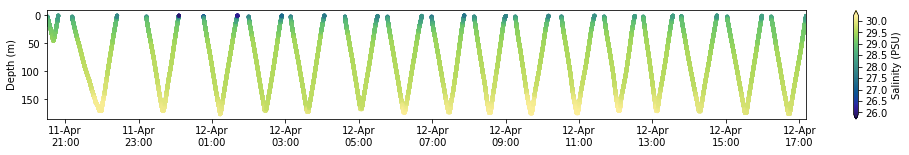

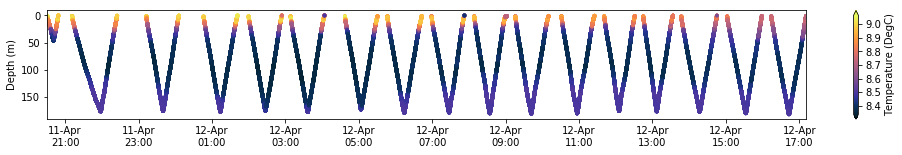

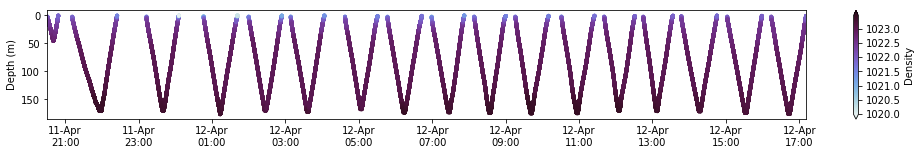

In [9]:
plot_params(dfs['sg403_PS_spring18'], 'salinity','Salinity (PSU)',cmocean.cm.haline)

plot_params(dfs['sg403_PS_spring18'], 'temperature','Temperature (DegC)')

plot_params(dfs['sg403_PS_spring18'], 'density','Density',cmocean.cm.dense)

In [10]:
### depth needs to be downsampled to the other database freqencyies to plot chlor/oxy

dfwet = dfs['sg403_PS_spring18_wetlabs'].join(dfs['sg403_PS_spring18'])
dfaan = dfs['sg403_PS_spring18_aanderaa'].join(dfs['sg403_PS_spring18'])

#quick QC
dfaan.aa4330_airsat[dfaan.aa4330_airsat < 0] =np.nan


/Volumes/WDC_internal/Users/bell/anaconda2/envs/dash/lib/python3.6/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


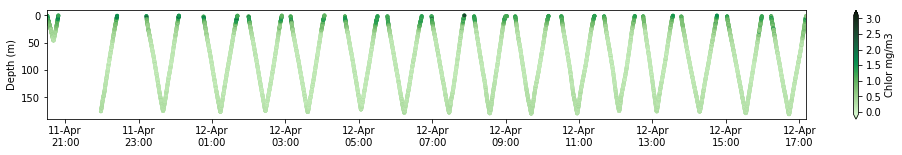

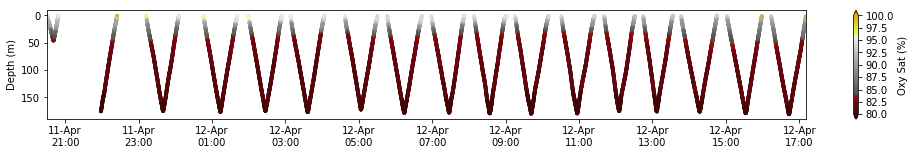

In [11]:
plot_params(dfwet, 'wlbb2fl_sig695nm_adjusted','Chlor mg/m3',cmocean.cm.algae)

plot_params(dfaan, 'aa4330_airsat','Oxy Sat (%)',cmocean.cm.oxy,vmin=80,vmax=100)

#### waterfall plots

In [12]:
def plot_waterfall(dfg, var=None,varstr='',delta=1):
    fig, ax = plt.subplots(figsize=(8, 12))
    shift = 0
    for g in dfg.groups:
        df = dfg.get_group(g)
        cs = ax.plot(df[var]+shift, df['ctd_depth'])
        shift=shift+delta

        
    ax.invert_yaxis()
    ax.set_ylabel('Depth (m)')
    ax.set_xlabel(varstr)


In [13]:
dfg = dfs['sg403_PS_spring18'].groupby('profileid')
dfwg = dfwet.groupby('profileid')

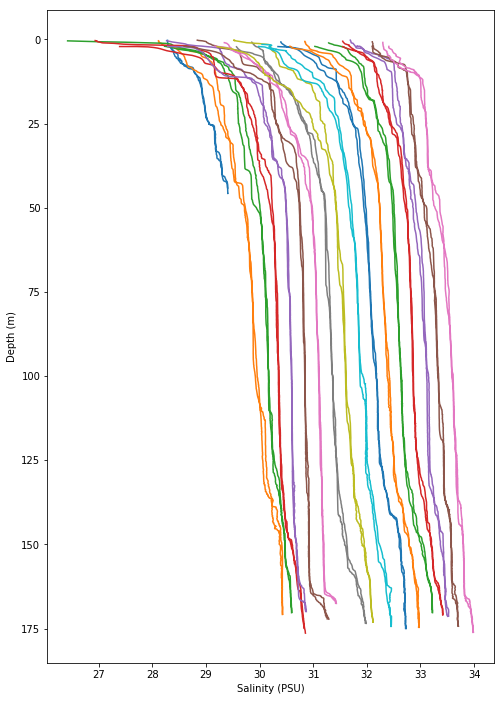

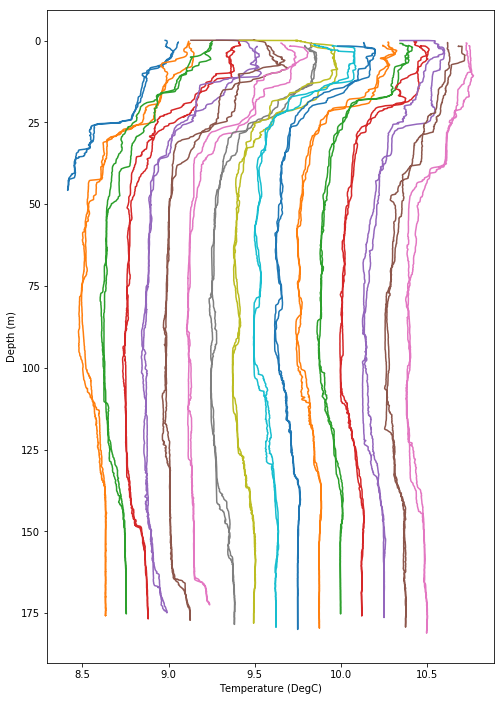

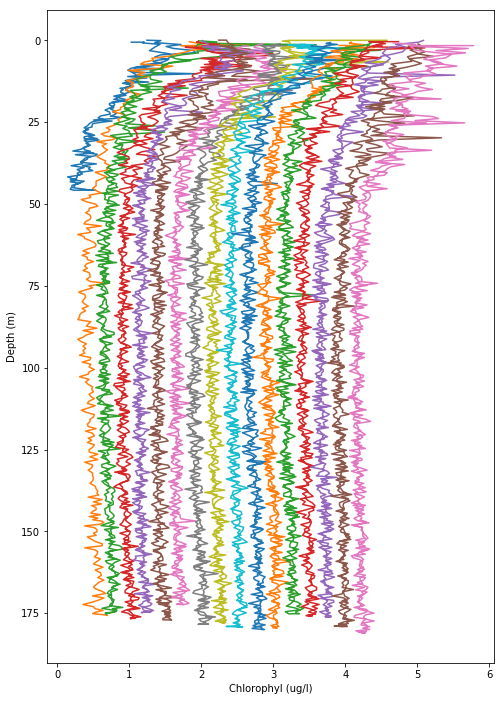

In [14]:
plot_waterfall(dfg, 'salinity','Salinity (PSU)',.25)
plot_waterfall(dfg, 'temperature','Temperature (DegC)',.125)
plot_waterfall(dfwg, 'wlbb2fl_sig695nm_adjusted','Chlorophyl (ug/l)',.25)

## Plotly Test

In [15]:
import plotly.plotly as py
import plotly.graph_objs as go

import plotly
plotly.tools.set_credentials_file(username='shaun.bell', api_key='Iy4hhKvFuwXaSMm78Xjl')


In [16]:
def cmocean_to_plotly(cmap, pl_entries):
    h = 1.0/(pl_entries-1)
    pl_colorscale = []
    
    for k in range(pl_entries):
        C = list(map(np.uint8, np.array(cmap(k*h)[:3])*255))
        pl_colorscale.append([k*h, 'rgb'+str((C[0], C[1], C[2]))])
        
    return pl_colorscale

thermal = cmocean_to_plotly(cmocean.cm.thermal, 1000)
algae = cmocean_to_plotly(cmocean.cm.algae, 1000)

*** Too big a data set... parse it down and it may be ok ***

Try running a ploty/dash application

In [17]:
dfr = dfs['sg403_PS_spring18'].resample('1s').mean()
dfwet = dfs['sg403_PS_spring18_wetlabs'].join(dfs['sg403_PS_spring18'])


In [27]:
start_date=datetime.datetime(2018, 4, 12)
end_date=datetime.datetime.now()
param_ctd='temperature'

###
figure={
    'data': [
        go.Scattergl(
            x = dfr[start_date:end_date].index,
            y = dfr[start_date:end_date]['ctd_depth'],
            mode = 'markers',
            marker={
                'size': 8,
                'color': dfr[start_date:end_date][param_ctd], #set color equal to a variable
                'colorscale': thermal,
                'showscale': True
            },
            name=dfr[start_date:end_date][param_ctd],
            text=dfr[start_date:end_date][param_ctd]
        )
    ],
    'layout': go.Layout(
        xaxis={'title': 'Time'},
        yaxis={'title': 'Depth', 'autorange': 'reversed'}
    )
}
fig2 = go.Figure(data=figure['data'], layout=figure['layout'])
py.iplot(fig2, filename='axes-range-mode-temp')


In [19]:
figure={
    'data': [
        go.Scattergl(
            x = dfwet.index,
            y = dfwet['ctd_depth'],
            mode = 'markers',
            marker={
                'size': 8,
                'color': dfwet['wlbb2fl_sig695nm_adjusted'], #set color equal to a variable
                'colorscale': algae,
                'showscale': True
            }
        )
    ],
    'layout': go.Layout(
        xaxis={'title': 'Time'},
        yaxis={'title': 'Depth', 'autorange': 'reversed'}
    )
}
fig1 = go.Figure(data=figure['data'], layout=figure['layout'])
py.iplot(fig1, filename='axes-range-mode-chlor')


In [20]:
def plot_waterfall(dfg, var=None,varstr='',delta=1):
    shift = 0
    dataPanda = []
    for g in dfg.groups:
        df = dfg.get_group(g)

        trace = go.Scatter(
                    x = df[var]+shift,
                    y = df['ctd_depth'],
                    mode = 'line',
                    name = g
                ) 
        dataPanda.append(trace)
        
        shift = shift + delta
    layout =  go.Layout(
    xaxis={'title': varstr},
    yaxis={'title': 'Depth', 'autorange': 'reversed'}
    )
        

    fig1 = go.Figure(data=dataPanda, layout=layout)

        
    return fig1


In [21]:
py.iplot(plot_waterfall(dfg, 'salinity','Salinity (PSU)',.25), filename='waterfall-sal')


The draw time for this plot will be slow for clients without much RAM.


/Volumes/WDC_internal/Users/bell/anaconda2/envs/dash/lib/python3.6/site-packages/plotly/api/v1/clientresp.py:40: UserWarning:

Estimated Draw Time Slow



In [22]:
py.iplot(plot_waterfall(dfg, 'temperature','Temperature (DegC)',.125), filename='waterfall-temp')


The draw time for this plot will be slow for clients without much RAM.


/Volumes/WDC_internal/Users/bell/anaconda2/envs/dash/lib/python3.6/site-packages/plotly/api/v1/clientresp.py:40: UserWarning:

Estimated Draw Time Slow



In [23]:
py.iplot(plot_waterfall(dfwg, 'wlbb2fl_sig695nm_adjusted','Chlorophyl (ug/l)',.25), filename='waterfall-chlor')

Todo:   
- transfer plotly waterfall plots to a dash utility and allow a divenumber to be chosen with a +/- 10 plt window around it plotted
- cleanup and annotate this page
- put links to dash routines running on pavlof 